In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import importlib
import helpers
importlib.reload(helpers)  
from helpers import (plot_measurement_distribution, compute_time_lagged_correlation,
                     compute_lag_matrix, plot_lag_matrix, analyze_flow_pattern)

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# **Exploratory Data Analysis**

In [2]:
df = pd.read_csv('continuous_factory_process.csv')

# Convert time_stamp to datetime
df['time_stamp'] = pd.to_datetime(df['time_stamp'])
duration = df['time_stamp'].max() - df['time_stamp'].min()
duration_hours = duration.total_seconds() / 3600

print(f"Data shape: {df.shape}")
print(f"Number of columns: {len(df.columns)}")
print(f"Time span: {df['time_stamp'].min()} to {df['time_stamp'].max()}")
print(f"Duration: {duration_hours:.2f} hours ({duration_hours * 60:.0f} minutes)")
print(f"Sampling rate: ~{len(df) / (duration_hours * 3600):.2f} Hz (should be ~1 Hz)")
print(f"\nMissing values per column:")
missing = df.isnull().sum()
print(missing[missing > 0] if missing.sum() > 0 else "No missing values!")
print(f"\nFirst few rows:")
df.head(5)

# Group variables by machine/stage for organized visualization
machine1_cols = [col for col in df.columns if 'Machine1' in col]
machine2_cols = [col for col in df.columns if 'Machine2' in col]
machine3_cols = [col for col in df.columns if 'Machine3' in col]
combiner_cols = [col for col in df.columns if 'Combiner' in col or 'combiner' in col.lower()]
machine4_cols = [col for col in df.columns if 'Machine4' in col]
machine5_cols = [col for col in df.columns if 'Machine5' in col]
primary_output_cols = [col for col in df.columns if 'Primary' in col]
secondary_output_cols = [col for col in df.columns if 'Secondary' in col]
ambient_cols = [col for col in df.columns if 'Ambient' in col]


print(f"Ambient conditions: {len(ambient_cols)}")
print(f"Stage 1 - Machine 1: {len(machine1_cols)}")
print(f"Stage 1 - Machine 2: {len(machine2_cols)}")
print(f"Stage 1 - Machine 3: {len(machine3_cols)}")
print(f"Combiner: {len(combiner_cols)}")
print(f"Stage 2 - Machine 4: {len(machine4_cols)}")
print(f"Stage 2 - Machine 5: {len(machine5_cols)}")
print(f"Primary outputs (Stage 1): {len(primary_output_cols)}")
print(f"Secondary outputs (Stage 2): {len(secondary_output_cols)}")
print(f"\nTotal: {len(ambient_cols) + len(machine1_cols) + len(machine2_cols) + len(machine3_cols) + len(combiner_cols) + len(machine4_cols) + len(machine5_cols) + len(primary_output_cols) + len(secondary_output_cols)} variables")

Data shape: (14088, 116)
Number of columns: 116
Time span: 2019-03-06 10:52:33 to 2019-03-06 14:47:20
Duration: 3.91 hours (235 minutes)
Sampling rate: ~1.00 Hz (should be ~1 Hz)

Missing values per column:
No missing values!

First few rows:
Ambient conditions: 2
Stage 1 - Machine 1: 12
Stage 1 - Machine 2: 12
Stage 1 - Machine 3: 12
Combiner: 3
Stage 2 - Machine 4: 7
Stage 2 - Machine 5: 7
Primary outputs (Stage 1): 0
Secondary outputs (Stage 2): 0

Total: 55 variables


Primary output columns (42-71): 30
Sample columns: ['Stage1.Output.Measurement0.U.Actual', 'Stage1.Output.Measurement0.U.Setpoint', 'Stage1.Output.Measurement1.U.Actual', 'Stage1.Output.Measurement1.U.Setpoint', 'Stage1.Output.Measurement2.U.Actual']


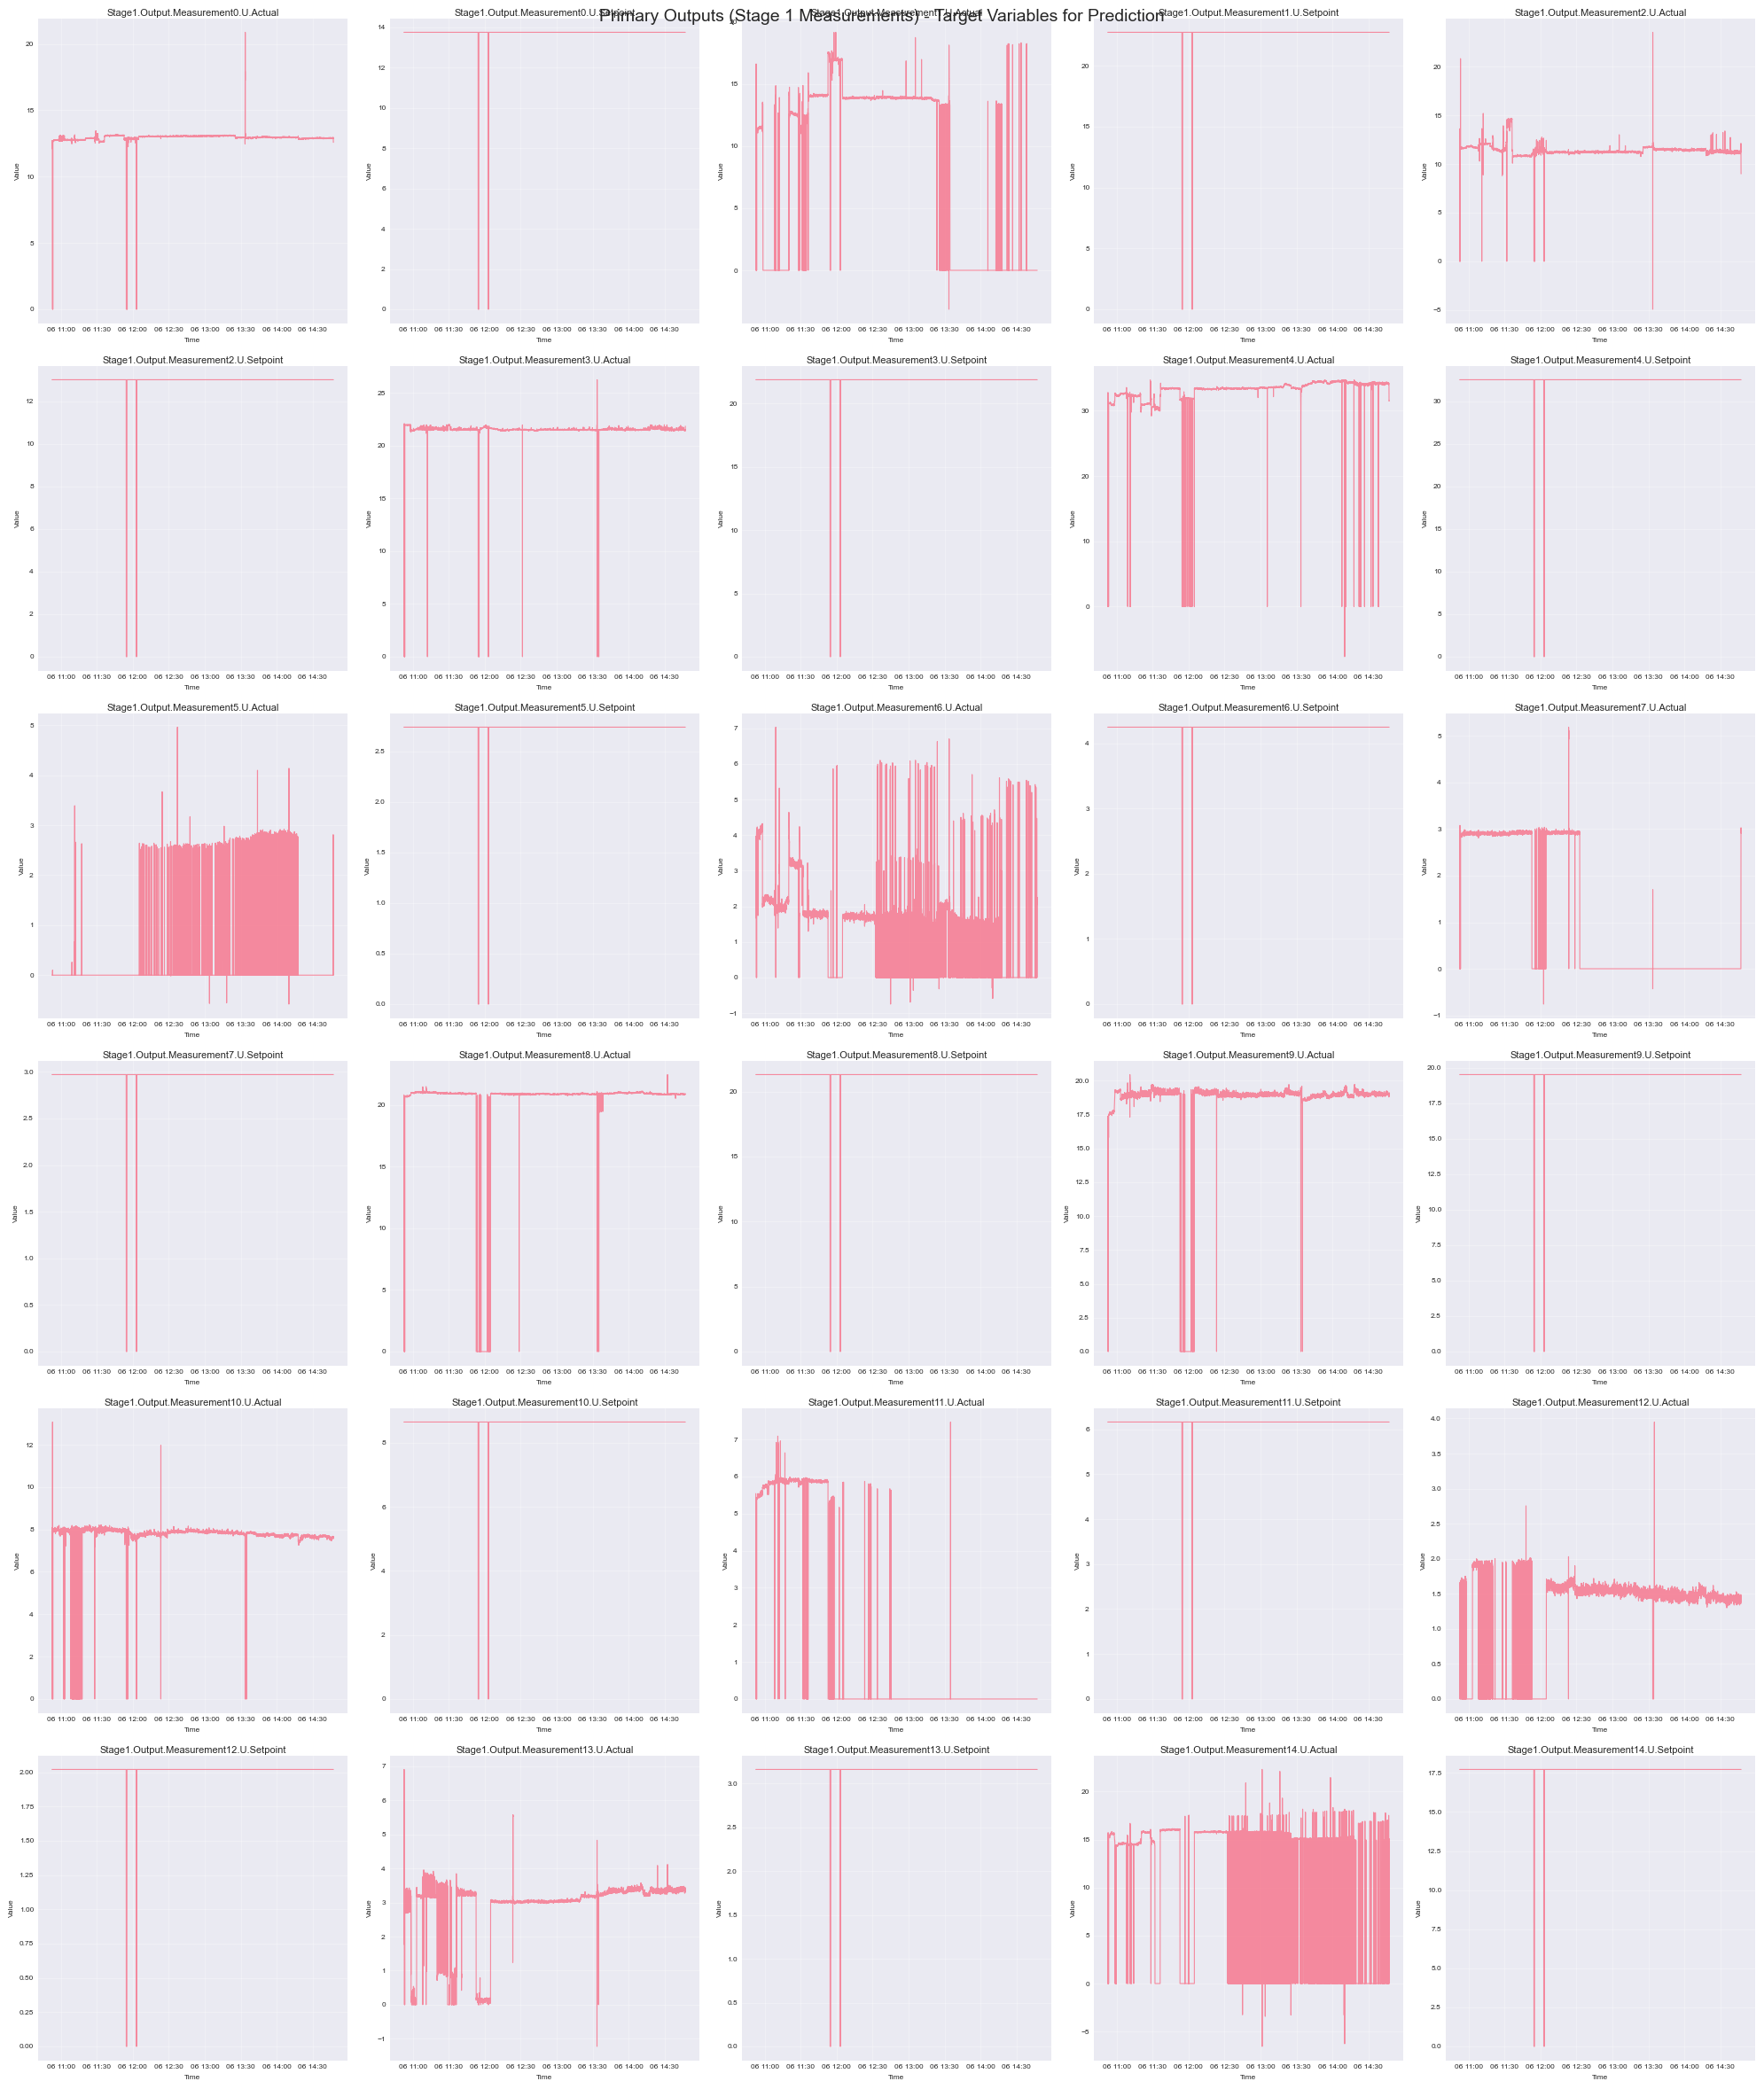

In [3]:
# Visualize PRIMARY OUTPUTS (15 measurements after Stage 1) - Main prediction targets
# Based on notes: columns 42-71 are primary outputs (15 measurements × 2 = 30 columns: Actual + Setpoint)

primary_cols = df.columns[42:72].tolist()
print(f"Primary output columns (42-71): {len(primary_cols)}")
print(f"Sample columns: {primary_cols[:5]}")

# Plot primary outputs in grid (5 columns per row)
n_primary = len(primary_cols)
cols_per_row = 5
n_rows = (n_primary + cols_per_row - 1) // cols_per_row

fig, axes = plt.subplots(n_rows, cols_per_row, figsize=(20, 4*n_rows))
fig.suptitle('Primary Outputs (Stage 1 Measurements) - Target Variables for Prediction', fontsize=14)

if n_rows == 1:
    axes = axes.reshape(1, -1)
axes = axes.flatten()

for idx, col in enumerate(primary_cols):
    ax = axes[idx]
    ax.plot(df['time_stamp'], df[col], linewidth=0.8, alpha=0.8)
    ax.set_title(col, fontsize=8, pad=2)
    ax.set_xlabel('Time', fontsize=6)
    ax.set_ylabel('Value', fontsize=6)
    ax.tick_params(labelsize=6)
    ax.grid(True, alpha=0.3)

# clean format - hide unused sub plots
for idx in range(len(primary_cols), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

In [4]:
# Separate Actual and Setpoint columns + Count zeros
actual_cols = [col for col in primary_cols if '.Actual' in col]
setpoint_cols = [col for col in primary_cols if '.Setpoint' in col]
zero_counts_actual = df[actual_cols].eq(0).sum()
zero_counts_setpoint = df[setpoint_cols].eq(0).sum()

print(f"\nZero counts in Actual measurements:")
print(zero_counts_actual[zero_counts_actual > 0].sort_values(ascending=False))

print(f"\nZero counts in Setpoint measurements:")
print(zero_counts_setpoint[zero_counts_setpoint > 0])

# Find rows where ALL outputs are zero (sensor reset events)
all_zero_mask = df[primary_cols].eq(0).all(axis=1)
reset_events = df[all_zero_mask]
print(f"Total rows with ANY zero value: {df[primary_cols].eq(0).any(axis=1).sum()}")
print(f"Rows where ALL outputs are zero (sensor resets): {len(reset_events)}")
print(f"Percentage of data affected: {len(reset_events) / len(df) * 100:.2f}%")

if len(reset_events) > 0:
    print(f"\nSensor reset event timestamps:")
    print(reset_events[['time_stamp']].head(20))
    print(f"\nTime range of reset events:")
    print(f"  First reset: {reset_events['time_stamp'].min()}")
    print(f"  Last reset: {reset_events['time_stamp'].max()}")


Zero counts in Actual measurements:
Stage1.Output.Measurement5.U.Actual     13400
Stage1.Output.Measurement11.U.Actual    10462
Stage1.Output.Measurement7.U.Actual      8761
Stage1.Output.Measurement1.U.Actual      5900
Stage1.Output.Measurement14.U.Actual     5005
Stage1.Output.Measurement6.U.Actual      4703
Stage1.Output.Measurement12.U.Actual     3188
Stage1.Output.Measurement8.U.Actual       777
Stage1.Output.Measurement9.U.Actual       722
Stage1.Output.Measurement13.U.Actual      341
Stage1.Output.Measurement10.U.Actual      268
Stage1.Output.Measurement4.U.Actual       174
Stage1.Output.Measurement3.U.Actual       135
Stage1.Output.Measurement2.U.Actual        85
Stage1.Output.Measurement0.U.Actual        70
dtype: int64

Zero counts in Setpoint measurements:
Stage1.Output.Measurement0.U.Setpoint     56
Stage1.Output.Measurement1.U.Setpoint     56
Stage1.Output.Measurement2.U.Setpoint     56
Stage1.Output.Measurement3.U.Setpoint     56
Stage1.Output.Measurement4.U.Setpoint    

Observations:
- Setpoints drop significantly. For ML model, add indicator and potentially impute vals 
    - in principle, setpoints most likely should not change
- actual output is extremely messy
    - zero inflation issue displayed below, distributions of stage 1 actual machine output

#### EXPLORATION OF ACTUAL MEASUREMENTS AND POTENTIALITY OF SEQUENTIAL LOCATIONS

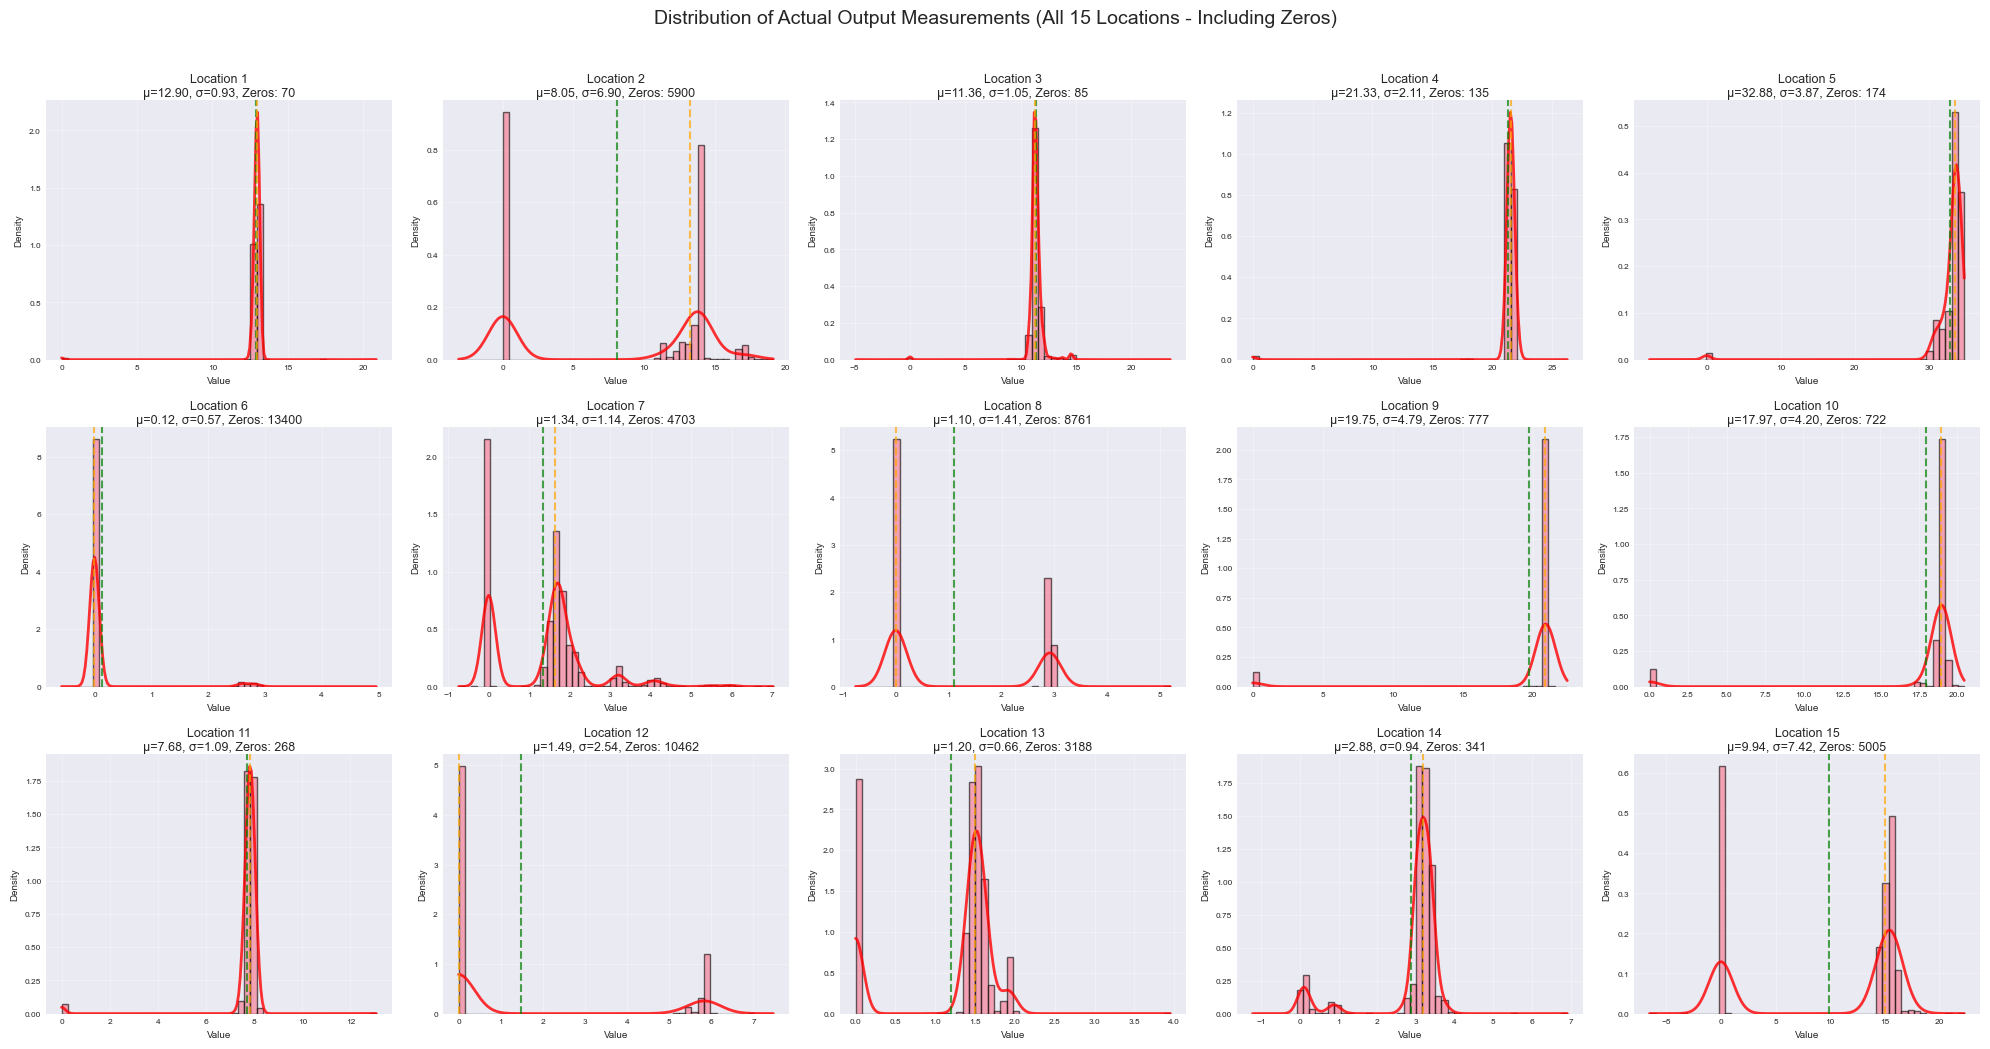

In [5]:
# Get primary output columns and separate Actual measurements
cols_per_row = 5
n_rows = (len(actual_cols) + cols_per_row - 1) // cols_per_row

fig, axes = plt.subplots(n_rows, cols_per_row, figsize=(20, 3.5*n_rows))
fig.suptitle('Distribution of Actual Output Measurements (All 15 Locations - Including Zeros)', 
             fontsize=14, y=0.995)

if n_rows == 1:
    axes = axes.reshape(1, -1)
axes = axes.flatten()

# Loop through all actual measurements using helper function
for idx, col in enumerate(actual_cols):
    ax = axes[idx]
    plot_measurement_distribution(col, df, ax, exclude_zeros=False)

# Hide unused subplots
for idx in range(len(actual_cols), len(axes)):
    axes[idx].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.98])  
plt.show()

# Exploring Sequential Flow 


In [6]:
# Time-lagged correlation analysis for Stage 1 outputs
# Exploring flow pattern: Are locations measured at different positions along the combiner?

# Prepare the 15 location series (Stage 1 Actual measurements)
location_series = {}
for i in range(15):
    col_name = f'Stage1.Output.Measurement{i}.U.Actual'
    location_series[f'Location{i+1}'] = df[col_name]

lag_result = compute_lag_matrix(location_series, max_lag=100, method='pearson')
print(f"\nLocation order (inferred from lag patterns): {lag_result['location_order']}") 

# looking at lag patterns with correlation weighting 
# Make copies to avoid read-only array issues
lag_df = lag_result['lag_matrix'].copy()
corr_df = lag_result['correlation_matrix'].copy()
# applying filter
threshold_corr = 0.3
max_reasonable_lag = 50

upstream_counts = {}
downstream_counts = {}

for loc in lag_df.index:
    upstream_count = 0
    downstream_count = 0
    
    for other_loc in lag_df.columns:
        if loc != other_loc:
            lag_val = lag_df.loc[loc, other_loc]
            corr_val = corr_df.loc[loc, other_loc]
            
            if abs(corr_val) > threshold_corr and abs(lag_val) < max_reasonable_lag:
                if lag_val > 0:  # This location leads the other (upstream)
                    upstream_count += 1
                elif lag_val < 0:  # Other location leads this one (downstream)
                    downstream_count += 1
    
    upstream_counts[loc] = upstream_count
    downstream_counts[loc] = downstream_count


summary_df = pd.DataFrame({
    'Upstream_Relationships': upstream_counts,
    'Downstream_Relationships': downstream_counts,
    'Net_Upstream_Score': {k: upstream_counts[k] - downstream_counts[k] 
                          for k in upstream_counts}
}).copy()

summary_df = summary_df.sort_values('Net_Upstream_Score', ascending=False)
print("\nLocation Analysis (sorted by net upstream score):")
print(summary_df)


Location order (inferred from lag patterns): ['Location7', 'Location15', 'Location5', 'Location11', 'Location10', 'Location2', 'Location8', 'Location6', 'Location12', 'Location1', 'Location9', 'Location14', 'Location3', 'Location13', 'Location4']

Location Analysis (sorted by net upstream score):
            Upstream_Relationships  Downstream_Relationships  \
Location10                       2                         0   
Location13                       2                         0   
Location3                        1                         0   
Location2                        0                         0   
Location4                        0                         0   
Location6                        0                         0   
Location7                        0                         0   
Location8                        0                         0   
Location11                       0                         0   
Location12                       0                         0 

In [7]:
# Check if locations are actually sequential by looking at adjacent pairs, if sequential i > i+1

sequential_evidence = []
for i in range(1, 15):  # Check Location1→Location2, Location2→Location3, etc.
    loc_i = f'Location{i}'
    loc_next = f'Location{i+1}'
    
    lag_val = lag_df.loc[loc_i, loc_next]
    corr_val = corr_df.loc[loc_i, loc_next]
    
    # Positive lag means loc_i leads loc_next (sequential flow)
    is_sequential = (lag_val > 0) and (abs(corr_val) > threshold_corr)
    
    sequential_evidence.append({
        'Pair': f'{loc_i} → {loc_next}',
        'Lag': lag_val,
        'Correlation': corr_val,
        'Is_Sequential': is_sequential,
        'Strong_Relationship': abs(corr_val) > threshold_corr
    })

seq_df = pd.DataFrame(sequential_evidence)
print(seq_df.to_string(index=False))

sequential_count = seq_df['Is_Sequential'].sum()
print(f"\n{'='*80}")
print(f"Sequential pairs found: {sequential_count} out of 14")
print(f"Percentage: {sequential_count/14*100:.1f}%")
print(f"{'='*80}")

                   Pair   Lag  Correlation  Is_Sequential  Strong_Relationship
  Location1 → Location2   0.0     0.138416          False                False
  Location2 → Location3  78.0    -0.206263          False                False
  Location3 → Location4   0.0     0.560314          False                 True
  Location4 → Location5   0.0     0.466694          False                 True
  Location5 → Location6 -90.0     0.053230          False                False
  Location6 → Location7   0.0     0.062887          False                False
  Location7 → Location8   0.0     0.545064          False                 True
  Location8 → Location9   0.0     0.159543          False                False
 Location9 → Location10   0.0     0.954057          False                 True
Location10 → Location11   0.0     0.171927          False                False
Location11 → Location12  85.0    -0.044756          False                False
Location12 → Location13 100.0    -0.548295          

## Key Finding: Locations Are NOT Sequential

**Evidence:**
- Only 2 out of 14 adjacent pairs show sequential flow (14.3%)
- Most pairs have **lag = 0** (measured simultaneously)
- Strong correlations exist but are **contemporaneous**, not lagged

**What this means:**
1. **Locations are likely measured at the same cross-section** (not along flow path)
2. **Different measurement properties** - Locations might measure different aspects (e.g., thickness, width, temperature, pressure)
3. **Flow is too fast** - At 1Hz sampling, flow time between locations might be < 1 second (undetectable)
4. **Complex geometry** - Combiner might have complex mixing/flow patterns, not linear

**The only sequential relationships:**
- Location12 → Location13 (lag=100, r=-0.55) - **NEGATIVE correlation!**
- Location13 → Location14 (lag=3, r=0.57) - Positive correlation

Even these are weak evidence - Location12→Location13 has negative correlation, suggesting inverse relationship.

In [9]:
# Analyze contemporaneous correlations (lag=0) to understand relationships
contemp_corrs = corr_df.copy()
for i in range(len(contemp_corrs)):
    contemp_corrs.iloc[i, i] = np.nan  # Remove self-correlations

# Find strongly correlated location pairs
strong_pairs = []
for i, loc1 in enumerate(contemp_corrs.index):
    for j, loc2 in enumerate(contemp_corrs.columns):
        if i < j:  # Only upper triangle to avoid duplicates
            corr_val = contemp_corrs.loc[loc1, loc2]
            if abs(corr_val) > 0.5:  # Strong correlation threshold
                strong_pairs.append({
                    'Location1': loc1,
                    'Location2': loc2,
                    'Correlation': corr_val,
                    'Type': 'Positive' if corr_val > 0 else 'Negative'
                })

strong_pairs_df = pd.DataFrame(strong_pairs).sort_values('Correlation', key=abs, ascending=False)
print(f"\nStrong contemporaneous relationships (|r| > 0.5):")
print(strong_pairs_df.to_string(index=False))

# Identify correlation clusters | Use correlation threshold to identify clusters
cluster_threshold = 0.6
clusters = []
visited = set()

for loc in contemp_corrs.index:
    if loc in visited:
        continue
    
    cluster = [loc]
    visited.add(loc)
    
    # Find all locations strongly correlated with this one
    for other_loc in contemp_corrs.columns:
        if other_loc not in visited:
            corr_val = contemp_corrs.loc[loc, other_loc]
            if abs(corr_val) > cluster_threshold:
                cluster.append(other_loc)
                visited.add(other_loc)
    
    if len(cluster) > 1:
        clusters.append(cluster)

print(f"\nFound {len(clusters)} correlation clusters (threshold: {cluster_threshold}):")
for i, cluster in enumerate(clusters, 1):
    print(f"  Cluster {i}: {', '.join(cluster)}")
    
# Locations with few strong relationships
isolated = [loc for loc in contemp_corrs.index 
            if loc not in [item for sublist in clusters for item in sublist]]
if isolated:
    print(f"\n  Isolated locations (few strong relationships): {', '.join(isolated)}")


Strong contemporaneous relationships (|r| > 0.5):
 Location1  Location2  Correlation     Type
 Location9 Location10     0.954057 Positive
 Location7 Location15     0.782617 Positive
 Location8 Location12     0.723592 Positive
 Location1  Location4     0.690621 Positive
Location10 Location14     0.664890 Positive
 Location1  Location3     0.648980 Positive
 Location9 Location14     0.647728 Positive
 Location1  Location5     0.591623 Positive
Location13 Location14     0.566051 Positive
 Location3  Location4     0.560314 Positive
Location12 Location13    -0.548295 Negative
 Location7  Location8     0.545064 Positive
 Location7 Location12     0.510784 Positive

Found 4 correlation clusters (threshold: 0.6):
  Cluster 1: Location1, Location3, Location4
  Cluster 2: Location7, Location15
  Cluster 3: Location8, Location12
  Cluster 4: Location9, Location10, Location14

  Isolated locations (few strong relationships): Location2, Location5, Location6, Location11, Location13


## Interpretation of Correlation Clusters

**Key Findings:**

### **Cluster 1: Locations 1, 3, 4** (r > 0.56-0.69)
- These locations move together strongly
- Likely measuring similar properties or same region

### **Cluster 2: Locations 7, 15** (r = 0.78)
- Strong relationship despite being far apart (7 vs 15)
- Not sequential, but highly correlated, might be measuring complementary properties

### **Cluster 3: Locations 8, 12** (r = 0.72)
- Strong positive correlation
- Location12 also has negative correlation with Location13 (-0.55)

### **Cluster 4: Locations 9, 10, 14** (r > 0.64-0.95)
- Very strong correlations, especially 9-10 (r=0.95)
- Modeling: Might be able to use one to predict others

### **Isolated Locations: 2, 5, 6, 11, 13**
- Few strong relationships with other locations
- Might be measuring unique properties

### **Negative Correlation:**
- Location12 ↔ Location13 (r = -0.55)
- **Important**: Inverse relationship suggests different measurement properties
- Could be measuring opposite sides, different dimensions, or competing processes

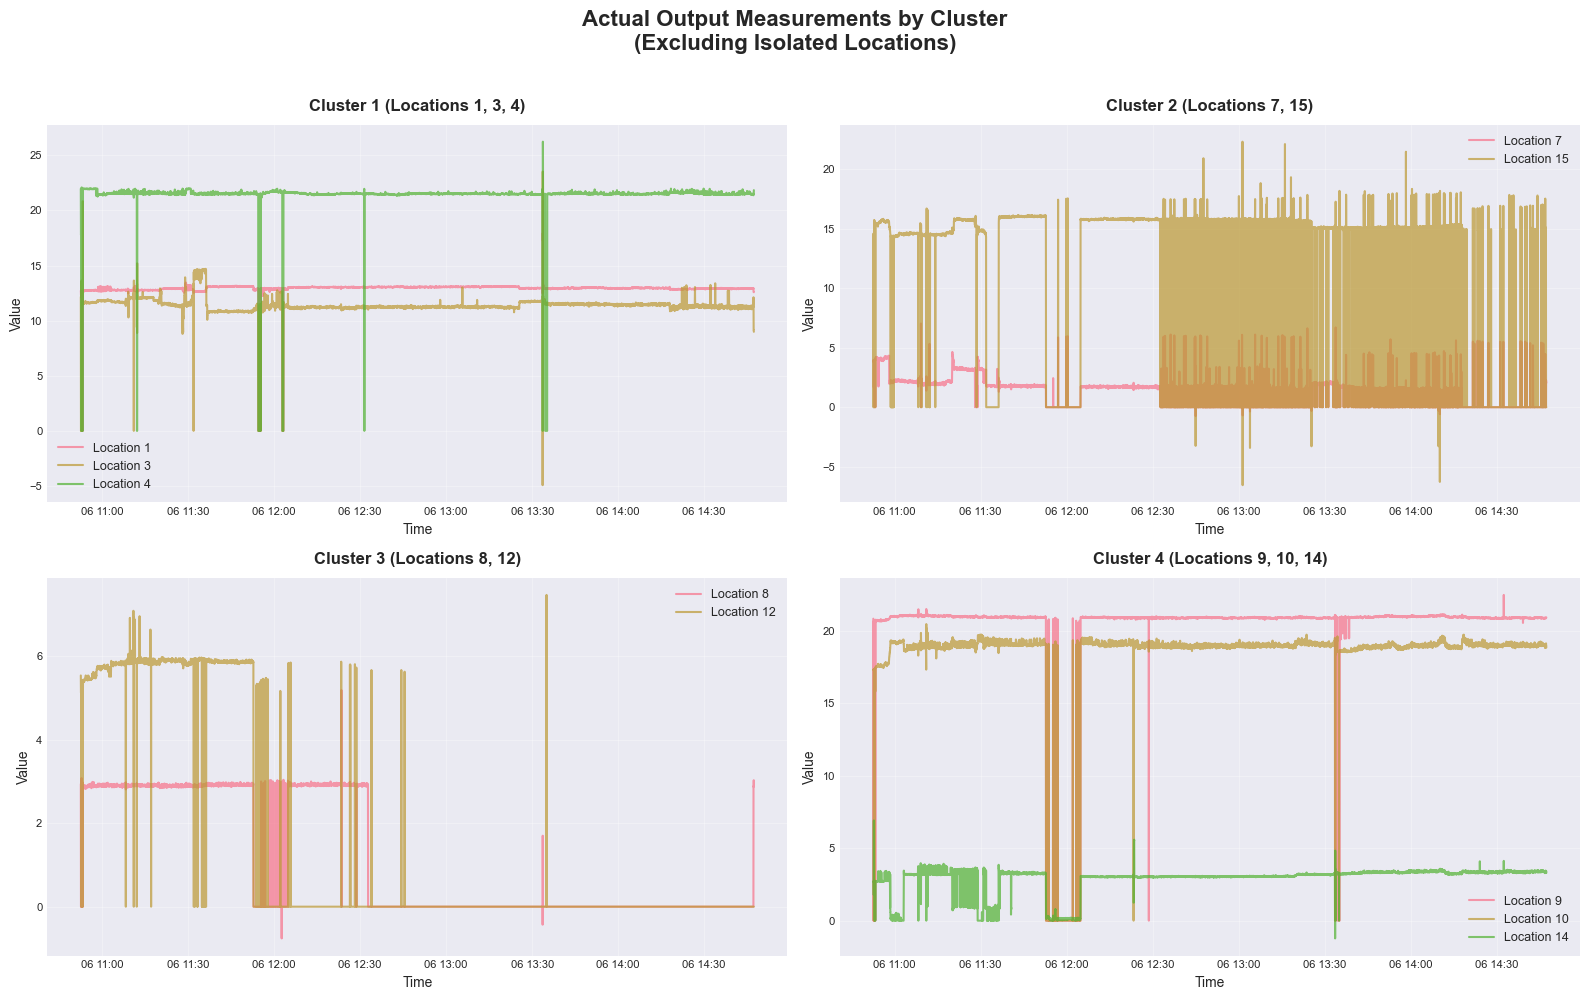

In [11]:
# Visualize clusters of actual output measurements

clusters = {
    'Cluster 1 (Locations 1, 3, 4)': [1, 3, 4],
    'Cluster 2 (Locations 7, 15)': [7, 15],
    'Cluster 3 (Locations 8, 12)': [8, 12],
    'Cluster 4 (Locations 9, 10, 14)': [9, 10, 14]
}

# Create subplot for each cluster
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Actual Output Measurements by Cluster\n(Excluding Isolated Locations)', 
             fontsize=16, fontweight='bold', y=0.995)

axes = axes.flatten()

for cluster_idx, (cluster_name, location_nums) in enumerate(clusters.items()):
    ax = axes[cluster_idx]
    
    # Plot each location in the cluster
    for loc_num in location_nums:
        col_name = f'Stage1.Output.Measurement{loc_num-1}.U.Actual'  # 0-indexed
        ax.plot(df['time_stamp'], df[col_name], 
               label=f'Location {loc_num}', linewidth=1.5, alpha=0.7)
    
    ax.set_title(cluster_name, fontsize=12, fontweight='bold', pad=10)
    ax.set_xlabel('Time', fontsize=10)
    ax.set_ylabel('Value', fontsize=10)
    ax.legend(fontsize=9, loc='best')
    ax.grid(True, alpha=0.3)
    ax.tick_params(labelsize=8)

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

## Raw Materials and Process Variables

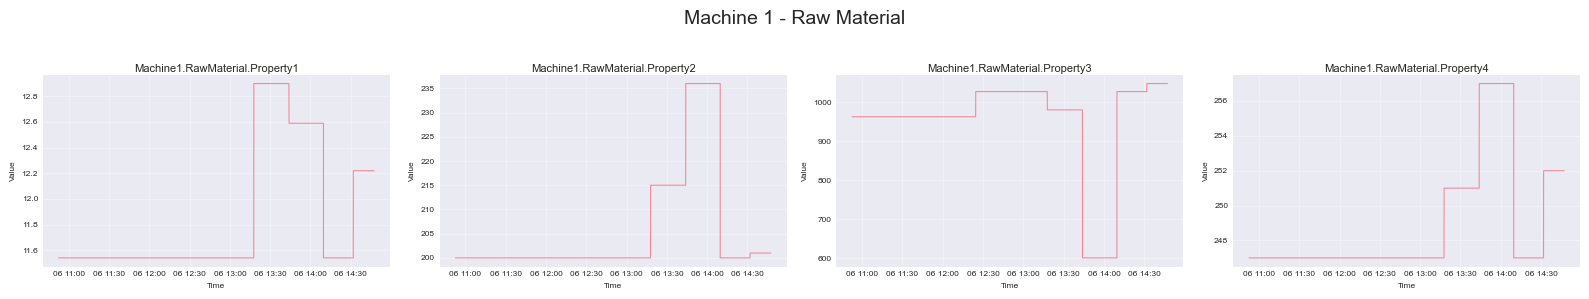

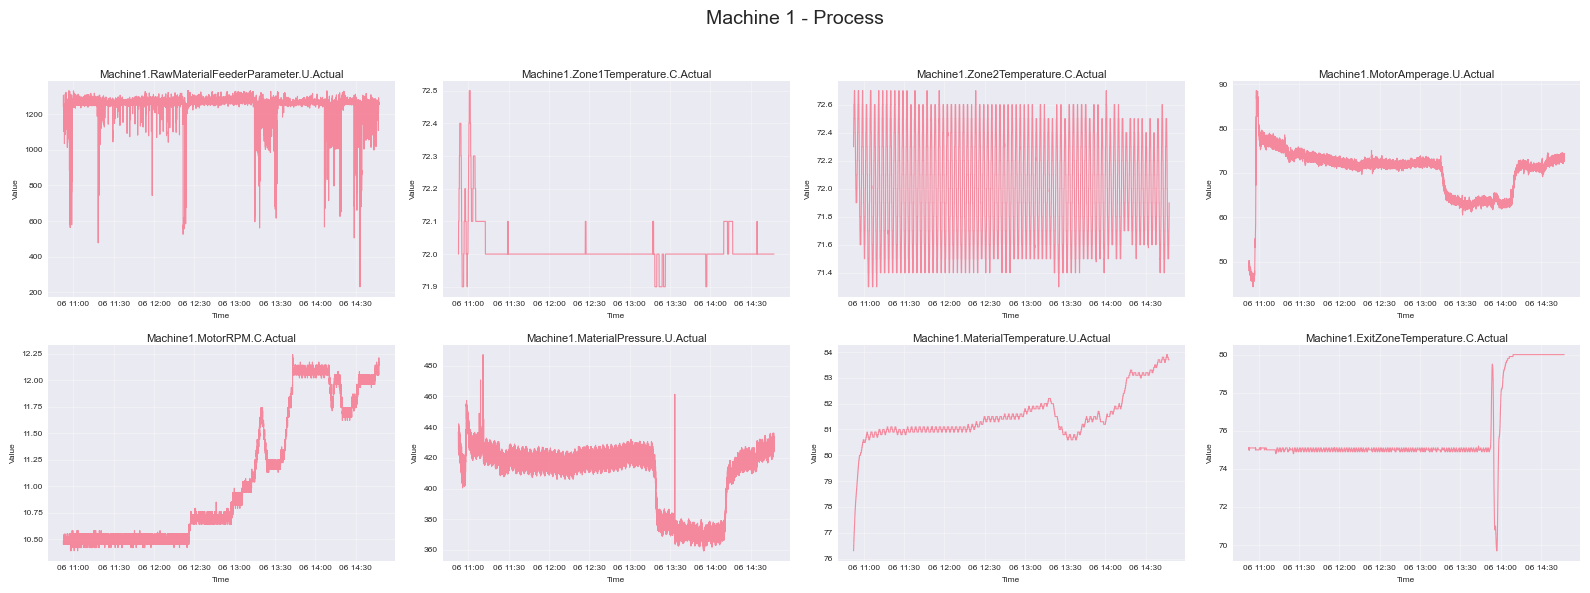

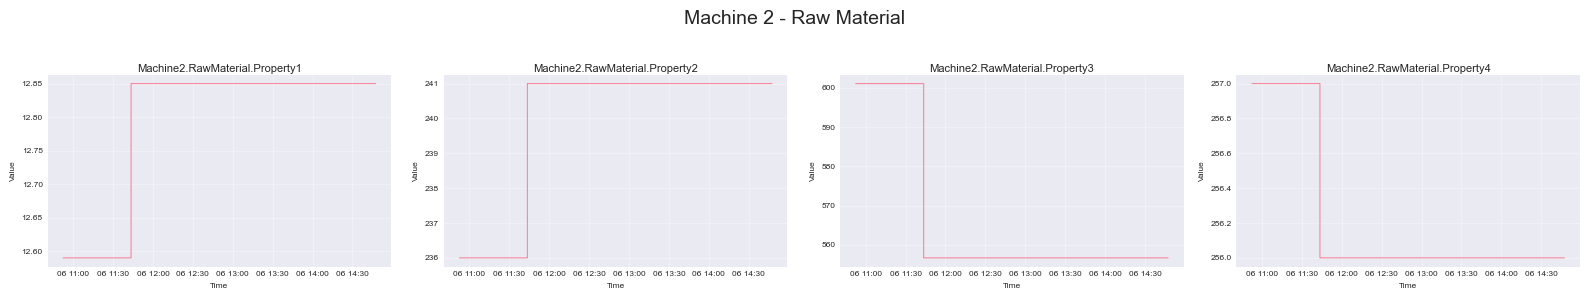

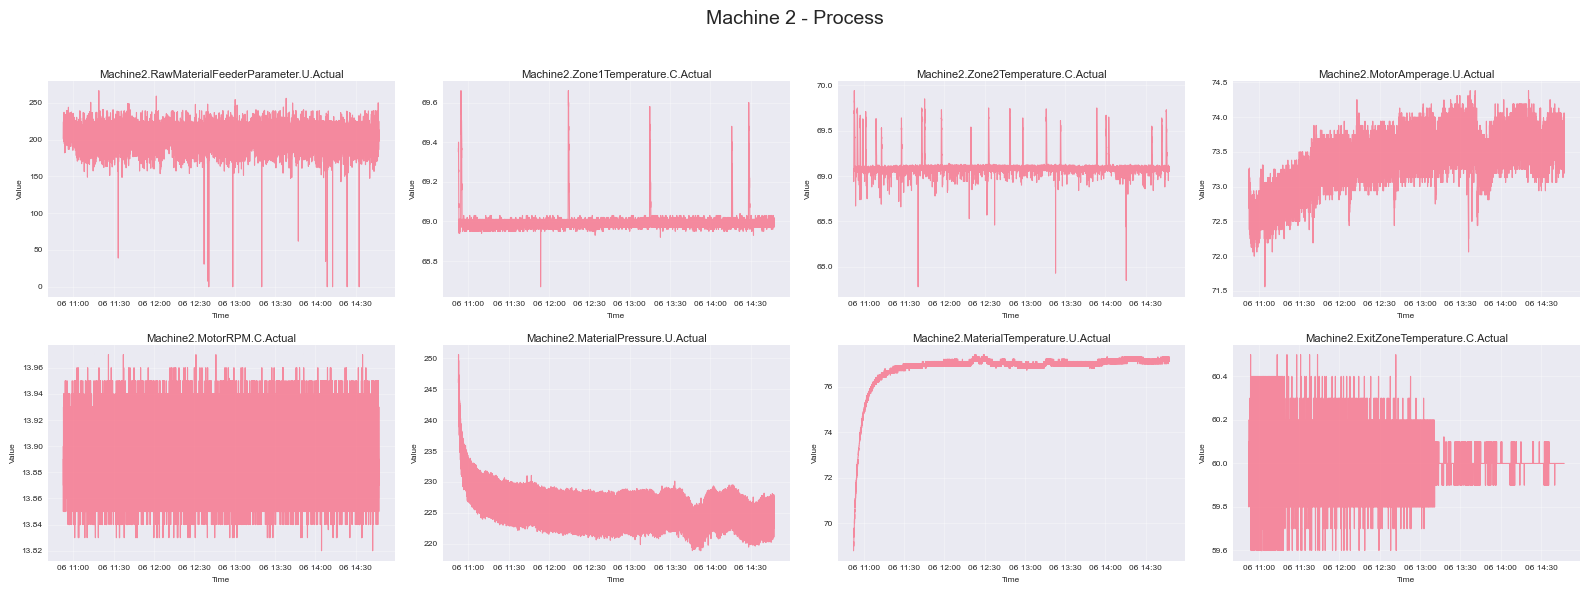

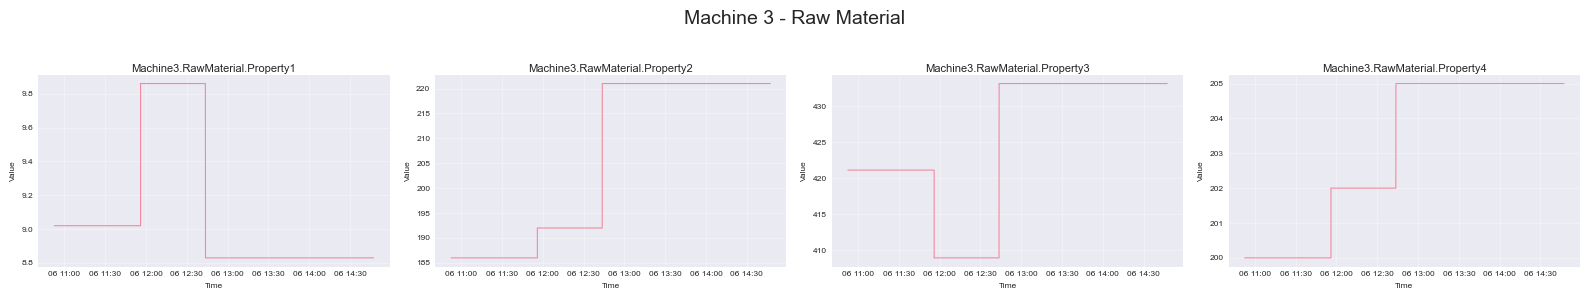

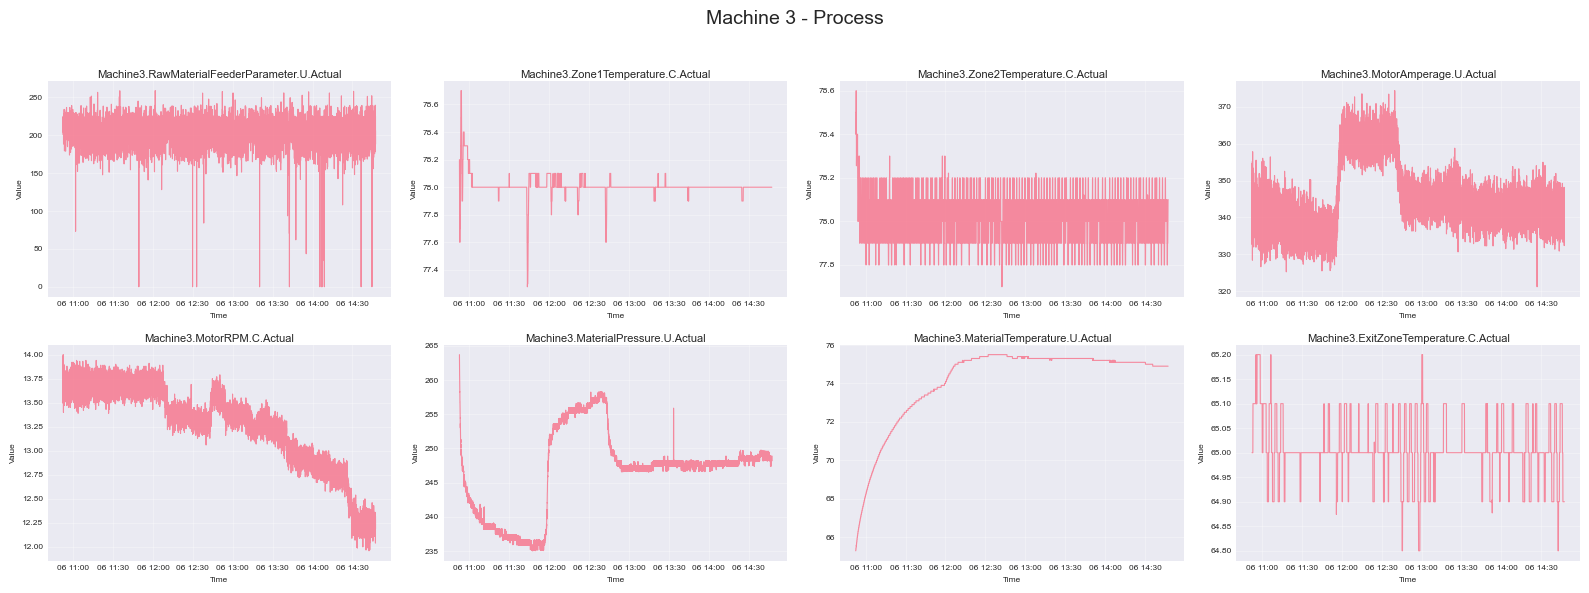

In [ ]:
m1_raw_cols = df.columns[3:7].tolist()
m1_proc_cols = df.columns[7:15].tolist()

m2_raw_cols = df.columns[15:19].tolist()
m2_proc_cols = df.columns[19:27].tolist()

m3_raw_cols = df.columns[27:31].tolist()
m3_proc_cols = df.columns[31:39].tolist()

# Time-series plots for raw material properties and process variables

machine_configs = {
    'Machine 1 - Raw Material': m1_raw_cols,
    'Machine 1 - Process': m1_proc_cols,
    'Machine 2 - Raw Material': m2_raw_cols,
    'Machine 2 - Process': m2_proc_cols,
    'Machine 3 - Raw Material': m3_raw_cols,
    'Machine 3 - Process': m3_proc_cols,
}

for title, cols in machine_configs.items():
    if not cols:
        continue
    
    n_cols = min(4, len(cols))
    n_rows = (len(cols) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
    fig.suptitle(title, fontsize=14)
    
    if n_rows == 1 and n_cols == 1:
        axes = np.array([[axes]])
    elif n_rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()
    
    for idx, col in enumerate(cols):
        ax = axes[idx]
        ax.plot(df['time_stamp'], df[col], linewidth=0.8, alpha=0.8)
        ax.set_title(col, fontsize=8, pad=2)
        ax.set_xlabel('Time', fontsize=6)
        ax.set_ylabel('Value', fontsize=6)
        ax.tick_params(labelsize=6)
        ax.grid(True, alpha=0.3)
    
    # Hide unused subplots
    for idx in range(len(cols), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()